In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1
ACTIONS = [ACTION_HIT, ACTION_STAND]

# policy for player
POLICY_PLAYER = np.zeros(22, dtype=np.int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

# policy for dealer
POLICY_DEALER = np.zeros(22, dtype=np.int)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of a card (11 for ace)
def card_value(card_id):
    return 11 if card_id == 1 else card_id

In [3]:
# function form of target pollicy of player
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# function form of behavior policy of player
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

In [4]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):
    # player status

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:
        # generate a random initial state

        while player_sum < 12:
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)

            # If the player's sum is larger than 21, he may hold one or two aces
            if player_sum > 21:
                assert player_sum == 22
                # last card must be ace
                player_sum -= 10
            else:
                usable_ace_player |= (1 == card)
            
        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()
    
    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()
    
    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # game starts!

    # player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break

        # if hit, get new card
        card = get_card()
        # Keep track of the ace count.
        # the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory

In [5]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)
        
    rhos = np.asarray(rhos)
    returns = np.asarray(returns)    
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    # with np.errstate(divide='ignore', invalid='ignore'):
    #     weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)
    weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)
    
    return ordinary_sampling, weighted_sampling

In [6]:
def figure_5_3():
    np.random.set_state(random_state)

    true_value = -0.27726
    episodes = 10000
    runs = 100

    error_ordinary = np.zeros(episodes)
    error_weighted = np.zeros(episodes)

    for i in trange(runs):
        ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
        # get the squared error
        error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
        error_weighted += np.power(weighted_sampling_ - true_value, 2)
    error_ordinary /= runs
    error_weighted /= runs

    plt.plot(error_ordinary, label="Ordinary Importance Sampling")
    plt.plot(error_weighted, label="Weighted Importance Sampling")
    plt.xlabel("Episodes (log scale)")
    plt.ylabel("Mean equare error")
    plt.xscale('log')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


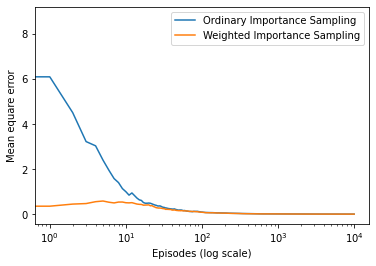

In [7]:
figure_5_3()